In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mat73
import scipy.io as sio
from scipy.ndimage import gaussian_filter

In [3]:
data = mat73.loadmat("/Users/bhoomi/Desktop/CS 736/Assignment3_22B0623_22B0704 2/data/assignmentSegmentBrain.mat")
data

{'imageData': array([[0.01509826, 0.01886725, 0.02461856, ..., 0.02028591, 0.04449398,
         0.05579706],
        [0.03601538, 0.01501652, 0.02221822, ..., 0.05049168, 0.05145801,
         0.06766721],
        [0.03767066, 0.02699185, 0.05561578, ..., 0.01715932, 0.04347878,
         0.02346222],
        ...,
        [0.0304323 , 0.03882585, 0.00485265, ..., 0.03000725, 0.03037082,
         0.07711918],
        [0.05833644, 0.02455803, 0.02609188, ..., 0.03058744, 0.01560842,
         0.03618063],
        [0.04709785, 0.02357   , 0.03824265, ..., 0.08944161, 0.06840941,
         0.01464482]], dtype=float32),
 'imageMask': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}

In [4]:
imageData = data['imageData']
imageMask = data['imageMask']

In [5]:
imageData.shape, imageMask.shape

((256, 256), (256, 256))

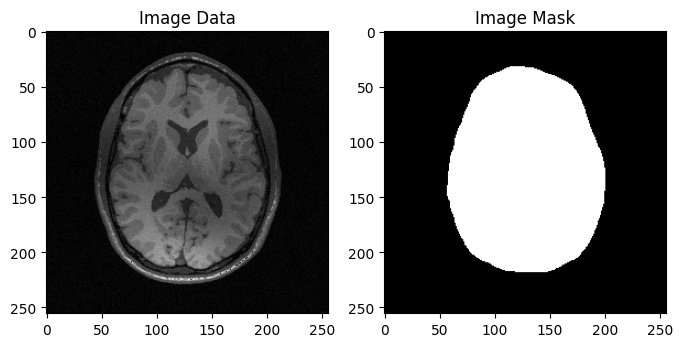

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(imageData, cmap='gray')
ax[0].set_title("Image Data")
ax[1].imshow(imageMask, cmap='gray')
ax[1].set_title("Image Mask")
plt.show()

In [7]:
q = 2      
K = 3              
max_iter = 50    
tol = 1e-4           
epsilon = 1e-6        

In [8]:
imageMask = (imageMask > 0)
brain_idx = np.where(imageMask)

In [9]:
b = np.ones_like(imageData)

In [10]:
u = np.zeros((imageData.shape[0], imageData.shape[1], K))
brain = imageData[imageMask]
low_thresh = np.percentile(brain, 33)
high_thresh = np.percentile(brain, 66)

In [11]:
u[..., 0] = 1.0*((imageData <= low_thresh) & imageMask)   #CSF
u[..., 1] = 1.0*((imageData > low_thresh) & (imageData <= high_thresh) & imageMask)   #GM
u[..., 2] = 1.0*((imageData > high_thresh) & imageMask)  # WM

In [12]:
u.shape

(256, 256, 3)

In [13]:
mask_zero = (imageMask) & (u.sum(axis=2)==0)
for k in range(K):
    u[..., k][mask_zero] = 1.0/K

In [14]:
s = np.sum(u, axis=2, keepdims=True)
s[s == 0] = 1  
u = u / s

For choosing the initial state of membership, the intensities from the brain region (using the provided mask) are extracted. <br>
Further, Intensity thresholds are computed at the 33rd and 66th percentiles, which roughly separate the low, medium, and high intensity ranges as expected for CSF, GM, and WM, respectively.<br>

Therefore, <br>
For pixels with intensity lower than the 33rd percentile, we assign a membership value of 1 to CSF and 0 to the other classes.<br>
For pixels with intensities between the 33rd and 66th percentiles, we assign a membership value of 1 to GM.<br>
For pixels with intensities above the 66th percentile, we assign a membership value of 1 to WM.<br>
Finally, we normalize the membership values so that for each pixel the sum across all classes equals 1. 

In [15]:
s.shape

(256, 256, 1)

In [16]:
init_memberships = [u[..., k].copy() for k in range(K)]

In [17]:
c = np.zeros(K)
for k in range(K):
    num = np.sum((u[..., k]**q)[imageMask] * b[imageMask] * imageData[imageMask])
    den = np.sum((u[..., k]**q)[imageMask] * (b[imageMask]**2))
    c[k] = num / (den + epsilon)

The initial class mean $c_k$ for class k is computed by taking a weighted sum of the observed intensities ImageData at nth pixel, (which are bias-corrected by the current bias estimate $b_n$) over all pixels inside the brain. <br>
Using a weighted average (with weights $u_(nk)^q$) ensures that pixels with higher confidence (i.e., those strongly belonging to a specific class) have a greater influence on the computed mean. This approach helps reduce the impact of noise and bias in the initial estimation.

In [18]:
mask_size = 7
sigma = 1.0
ax = np.arange(-mask_size//2 + 1, mask_size//2 + 1)
xx, yy = np.meshgrid(ax, ax)
gauss_kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
gauss_kernel /= gauss_kernel.sum()

In [19]:
objective_values = []
for iteration in range(max_iter):
    for k in range(K):
        num = np.sum((u[..., k]**q)[imageMask] * b[imageMask] * imageData[imageMask])
        den = np.sum((u[..., k]**q)[imageMask] * (b[imageMask]**2))
        c[k] = num / (den + epsilon)
    
    for idx in zip(*brain_idx):
        d = np.array([(imageData[idx] - b[idx]*c[k])**2 for k in range(K)]) + epsilon
        inv_d = d ** (-1/(q-1))
        u[idx[0], idx[1], :] = inv_d / np.sum(inv_d)
    
    b_new = b.copy()
    for idx in zip(*brain_idx):
        num = 0.0
        den = 0.0
        for k in range(K):
            num += (u[idx[0], idx[1], k]**q) * c[k] * imageData[idx]
            den += (u[idx[0], idx[1], k]**q) * (c[k]**2)
        b_new[idx] = num / (den + epsilon)
    b_new = gaussian_filter(b_new, sigma=1.0, mode='nearest')
    b = b_new.copy()
    
    J = 0.0
    for idx in zip(*brain_idx):
        for k in range(K):
            J += (u[idx[0], idx[1], k]**q) * ((imageData[idx] - b[idx]*c[k])**2)
    objective_values.append(J)
    
    if iteration > 0 and np.abs(objective_values[-1] - objective_values[-2]) < tol:
        print(f'Converged at iteration {iteration}')
        break

In [20]:
objective_values

[np.float64(28.170699973328716),
 np.float64(18.770476253061187),
 np.float64(16.153724510725073),
 np.float64(14.701158737789939),
 np.float64(13.697121393706666),
 np.float64(12.924810962882367),
 np.float64(12.29134507861253),
 np.float64(11.766603078351228),
 np.float64(11.343097545742994),
 np.float64(10.999405353175742),
 np.float64(10.716861275103977),
 np.float64(10.47274136565197),
 np.float64(10.26019934646222),
 np.float64(10.078471660206727),
 np.float64(9.923069479349081),
 np.float64(9.78963724364429),
 np.float64(9.674414897567877),
 np.float64(9.575843417689468),
 np.float64(9.486483658260942),
 np.float64(9.406055212088125),
 np.float64(9.33394289984396),
 np.float64(9.2729402406754),
 np.float64(9.220717289496886),
 np.float64(9.176752368909794),
 np.float64(9.139452045334203),
 np.float64(9.104142594395078),
 np.float64(9.070297230149654),
 np.float64(9.038130965185292),
 np.float64(9.008715816745825),
 np.float64(8.981387406103492),
 np.float64(8.957188812192845),
 

In [21]:
A = np.zeros_like(imageData)
R = np.zeros_like(imageData)
for idx in zip(*brain_idx):
    A[idx] = np.sum(u[idx[0], idx[1], :] * c)
    R[idx] = imageData[idx] - A[idx] * b[idx]

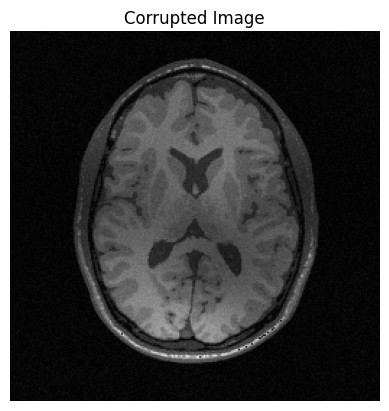

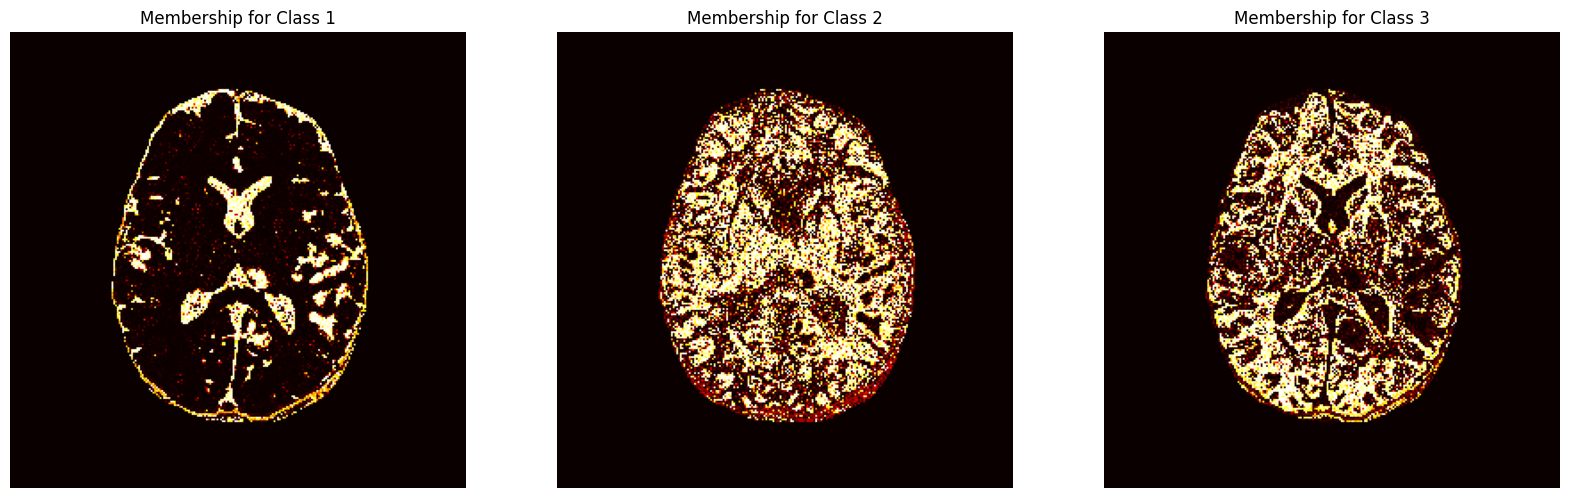

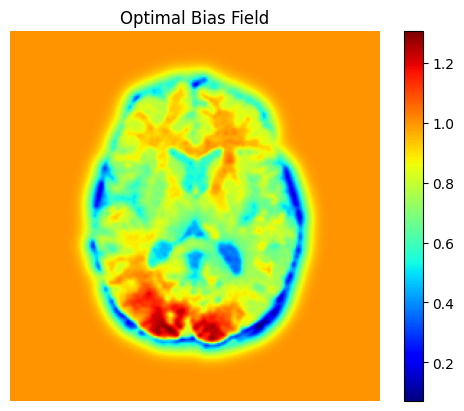

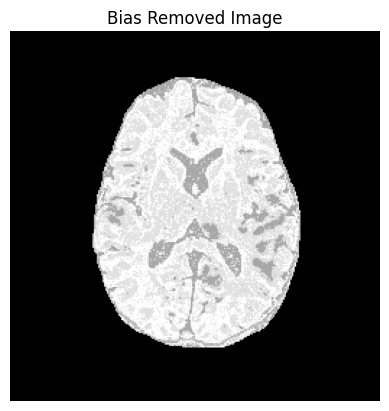

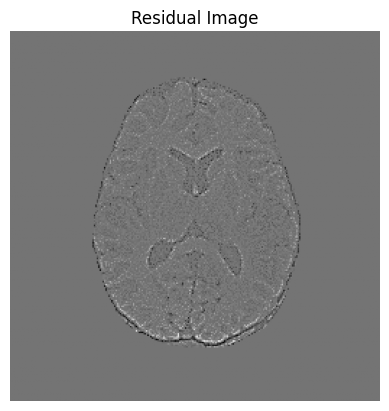

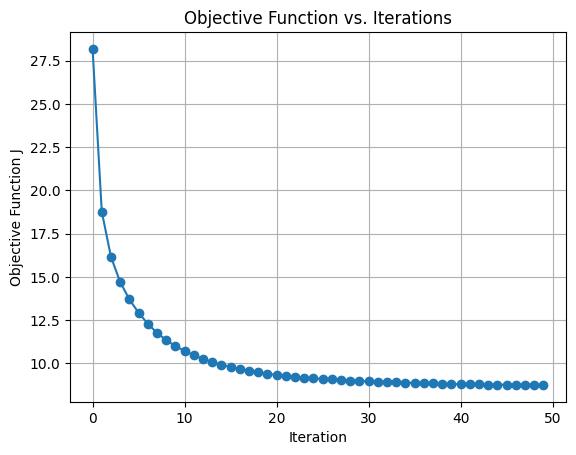

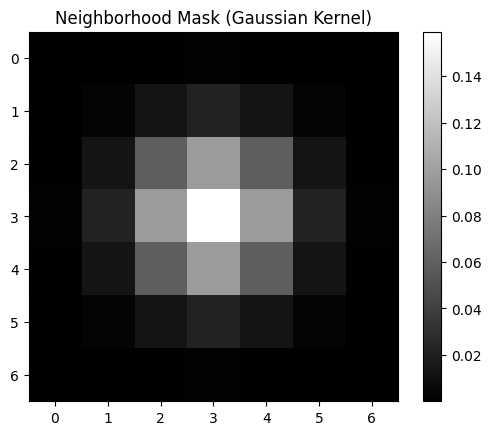

In [22]:
plt.figure()

plt.imshow(imageData, cmap='gray')
plt.title('Corrupted Image')
plt.axis('off')

plt.figure(figsize=(20, 8))
for k in range(K):
    plt.subplot(1, 3, 1+k)
    plt.imshow(u[..., k], cmap='hot')
    plt.title(f'Membership for Class {k+1}')
    plt.axis('off')

plt.figure()
plt.imshow(b, cmap='jet')
plt.title('Optimal Bias Field')
plt.colorbar()
plt.axis('off')

plt.figure()
plt.imshow(A, cmap='gray')
plt.title('Bias Removed Image')
plt.axis('off')

plt.figure()
plt.imshow(R, cmap='gray')
plt.title('Residual Image')
plt.axis('off')

plt.figure()
plt.plot(objective_values, marker='o')
plt.title('Objective Function vs. Iterations')
plt.xlabel('Iteration')
plt.ylabel('Objective Function J')
plt.grid(True)
plt.show()

plt.figure()
plt.imshow(gauss_kernel, cmap='gray', interpolation='nearest')
plt.title('Neighborhood Mask (Gaussian Kernel)')
plt.colorbar()
plt.show()

In [23]:
objective_values[-1]

np.float64(8.756398359811037)

In [24]:
print("Optimal class means (c_k):", c)

Optimal class means (c_k): [0.43084619 0.58572463 0.66383283]


It does not yield a unique solution because of an inherent scale ambiguity between the bias field $b_n$ and the class means $c_k$. In other words, if you multiply the bias field by a constant x and simultaneously divide the class means by x, the product $b_nc_k$ (which is what really matters in the reconstruction) remains unchanged. This means there is an infinite family of solutions that yield the same reconstruction error. <br>
To ensure uniqueness, we can force the mean value of the bias field over the brain region to be 1.

In [25]:
objective_values = []
for iteration in range(max_iter):
    for k in range(K):
        num = np.sum((u[..., k]**q)[imageMask] * b[imageMask] * imageData[imageMask])
        den = np.sum((u[..., k]**q)[imageMask] * (b[imageMask]**2))
        c[k] = num / (den + epsilon)
    
    for idx in zip(*brain_idx):
        d = np.array([(imageData[idx] - b[idx]*c[k])**2 for k in range(K)]) + epsilon
        inv_d = d ** (-1/(q-1))
        u[idx[0], idx[1], :] = inv_d / np.sum(inv_d)
    
    b_new = b.copy()
    for idx in zip(*brain_idx):
        num = 0.0
        den = 0.0
        for k in range(K):
            num += (u[idx[0], idx[1], k]**q) * c[k] * imageData[idx]
            den += (u[idx[0], idx[1], k]**q) * (c[k]**2)
        b_new[idx] = num / (den + epsilon)
    b_new = gaussian_filter(b_new, sigma=1.0, mode='nearest')
    b = b_new.copy()
    
    J = 0.0
    for idx in zip(*brain_idx):
        for k in range(K):
            J += (u[idx[0], idx[1], k]**q) * ((imageData[idx] - b[idx]*c[k])**2)
    objective_values.append(J)
    
    if iteration > 0 and np.abs(objective_values[-1] - objective_values[-2]) < tol:
        print(f'Converged at iteration {iteration}')
        break

In [581]:
A = np.zeros_like(imageData)
R = np.zeros_like(imageData)
for idx in zip(*brain_idx):
    A[idx] = np.sum(u[idx[0], idx[1], :] * c)
    R[idx] = imageData[idx] - A[idx] * b[idx]

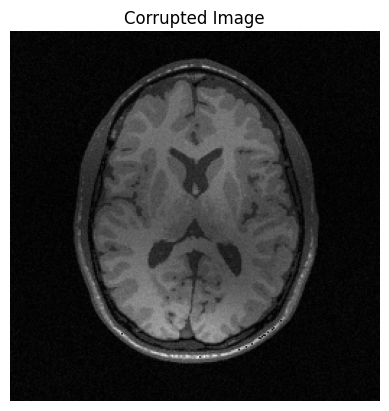

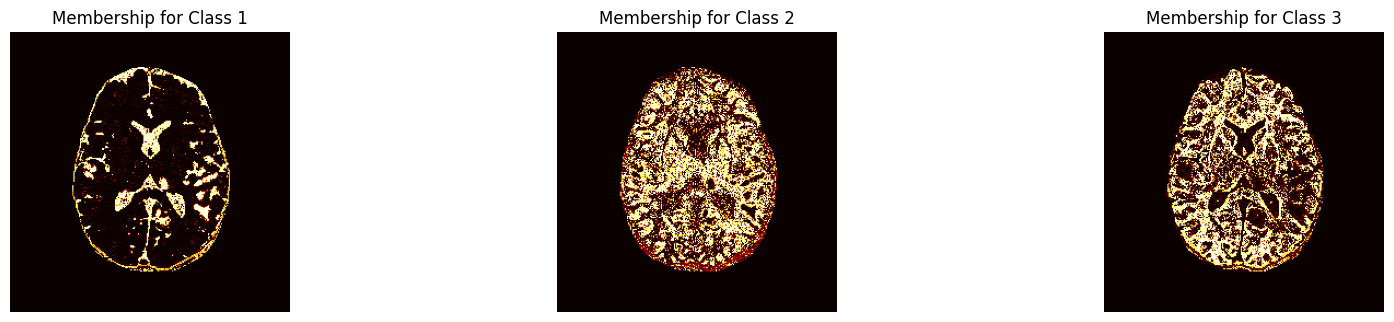

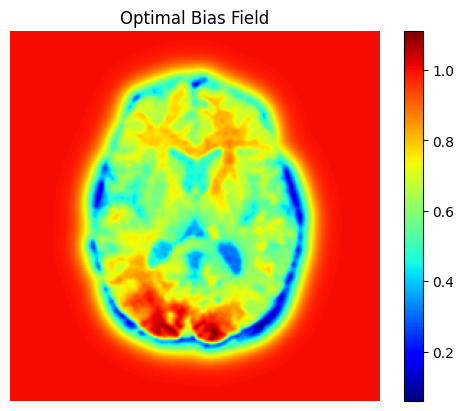

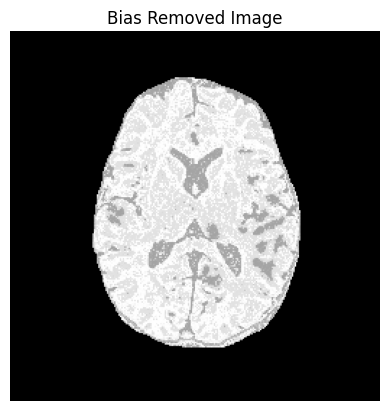

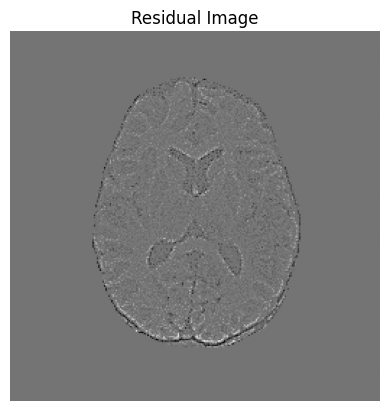

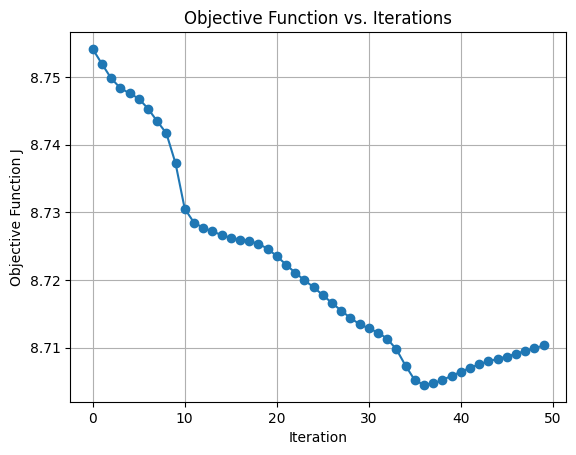

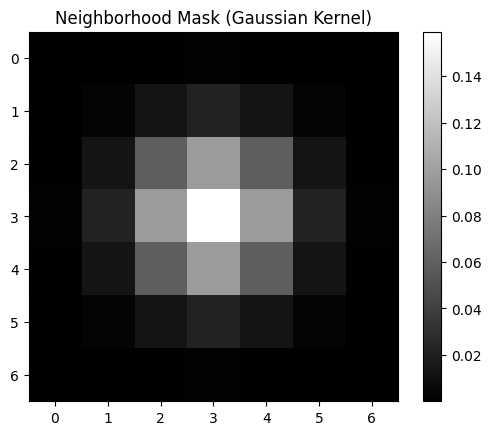

In [586]:
plt.figure()

# plt.subplot(2, 3, 1)
plt.imshow(imageData, cmap='gray')
plt.title('Corrupted Image')
plt.axis('off')

plt.figure(figsize=(20, 8))
for k in range(K):
    plt.subplot(2, 3, 1+k)
    plt.imshow(u[..., k], cmap='hot')
    plt.title(f'Membership for Class {k+1}')
    plt.axis('off')

plt.figure()
plt.imshow(b, cmap='jet')
plt.title('Optimal Bias Field')
plt.colorbar()
plt.axis('off')

plt.figure()
plt.imshow(A, cmap='gray')
plt.title('Bias Removed Image')
plt.axis('off')

plt.figure()
plt.imshow(R, cmap='gray')
plt.title('Residual Image')
plt.axis('off')

plt.figure()
plt.plot(objective_values, marker='o')
plt.title('Objective Function vs. Iterations')
plt.xlabel('Iteration')
plt.ylabel('Objective Function J')
plt.grid(True)
plt.show()

plt.figure()
plt.imshow(gauss_kernel, cmap='gray', interpolation='nearest')
plt.title('Neighborhood Mask (Gaussian Kernel)')
plt.colorbar()
plt.show()

In [26]:
print("Optimal class means (c_k):", c)

Optimal class means (c_k): [0.51027505 0.70271086 0.79548287]
